In [1]:
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CO, FHMMExact, Hart85, Mean
from nilmtk.legacy.disaggregate import CombinatorialOptimisation
from nilmtk_contrib.disaggregate import Seq2Seq, Seq2Point
from nilmtk.utils import print_dict
from nilmtk.api import API
import tensorflow as tf

tf.config.run_functions_eagerly(True)
tf.debugging.disable_traceback_filtering()
import pickle

In [2]:
experiment1 = {
  'power': {'mains': ['apparent','active'],'appliance': ['apparent','active']},
  'sample_rate': 1,
  'appliances': ['fridge', 'air conditioner', 'washing machine'],
#   'methods': {"Mean":Mean({}),"FHMM_EXACT":FHMMExact({'num_of_states':2}), "CO":CO({}), "Seq2Seq":Seq2Seq({}), "Seq2SPoint":Seq2Point({})},
'methods': {"Seq2Seq":Seq2Seq({}), "Seq2SPoint":Seq2Point({})},
  'train': {    
    'datasets': {
        'MIMOS': {
            'path': 'data/mimos_1sec.h5',
            'buildings': {
                1: {
                    'start_time': '2022-09-29',
                    'end_time': '2022-09-30'
                    }
                }                
            }
        }
    },
  'test': {
    'datasets': {
        'MIMOS': {
            'path': 'data/mimos_1sec.h5',
            'buildings': {
                2: {
                    'start_time': '2022-09-29',
                    'end_time': '2022-09-30'
                    }
                }
            }
        },
        'metrics':['mae', 'rmse', 'f1score']
    },
       'display_predictions': {
       True
   }
}

Joint Testing for all algorithms
Loading data for  MIMOS  dataset
Dropping missing values
Generating predictions for : Seq2Seq
7/7 [==============================] - 0s 5ms/step
Generating predictions for : Seq2Point
7/7 [==============================] - 0s 5ms/step
............  mae  ..............
                    Seq2Seq  Seq2SPoint
fridge            71.128166   86.064819
air conditioner    0.000080    0.040551
washing machine  102.792793  100.532608
............  rmse  ..............
                    Seq2Seq  Seq2SPoint
fridge           291.990983  415.239709
air conditioner    0.000631    0.090725
washing machine  106.987674  105.871670
............  f1score  ..............
                 Seq2Seq  Seq2SPoint
fridge           0.19174    0.327456
air conditioner  0.00000    0.000000
washing machine  0.00000    0.000000


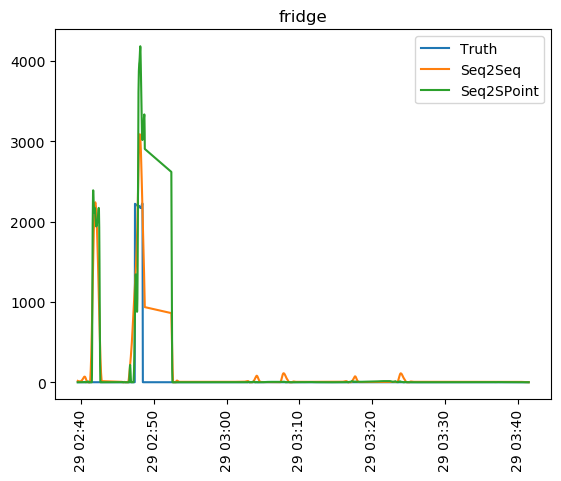

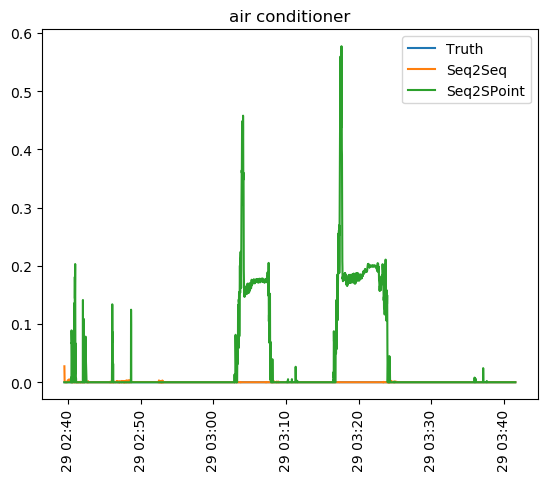

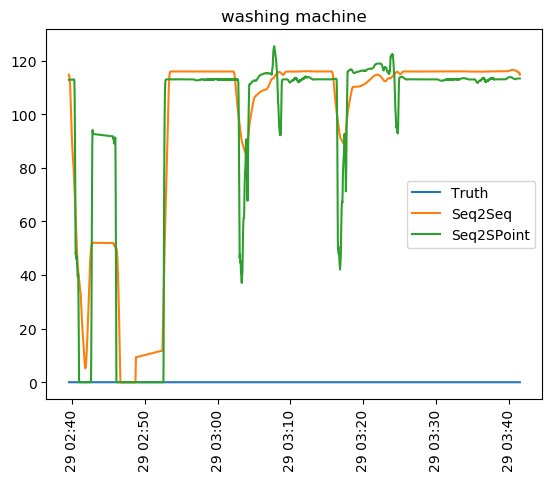

In [3]:
api_results_experiment_1 = API(experiment1)

In [4]:
def export_model(model,filename):
    example_dict = model
    with open(filename, "wb") as pickle_out:
        pickle.dump(example_dict, pickle_out)

In [5]:
export_model(api_results_experiment_1,'modelTrained_api.pickle')

INFO:tensorflow:Assets written to: ram://9f90026f-6405-471c-9402-8e7e3efce2f0/assets


INFO:tensorflow:Assets written to: ram://9f90026f-6405-471c-9402-8e7e3efce2f0/assets


INFO:tensorflow:Assets written to: ram://0fa91891-29c3-4665-9dd2-774ce3fd7126/assets


INFO:tensorflow:Assets written to: ram://0fa91891-29c3-4665-9dd2-774ce3fd7126/assets


INFO:tensorflow:Assets written to: ram://bd038df3-55a4-4738-b764-6fed0f6c5cbd/assets


INFO:tensorflow:Assets written to: ram://bd038df3-55a4-4738-b764-6fed0f6c5cbd/assets


INFO:tensorflow:Assets written to: ram://1a6ebeb8-1d14-4447-96ae-e111ca35c815/assets


INFO:tensorflow:Assets written to: ram://1a6ebeb8-1d14-4447-96ae-e111ca35c815/assets


INFO:tensorflow:Assets written to: ram://6f26bfa0-5c40-4488-a666-b3d0b74b36f5/assets


INFO:tensorflow:Assets written to: ram://6f26bfa0-5c40-4488-a666-b3d0b74b36f5/assets


INFO:tensorflow:Assets written to: ram://4096d70a-3cf2-44d3-9eb6-e1d0d7b64119/assets


INFO:tensorflow:Assets written to: ram://4096d70a-3cf2-44d3-9eb6-e1d0d7b64119/assets


In [6]:
def import_model(filename):
    with open(filename, "rb") as pickle_in:
        model = pickle.load(pickle_in)
        #states = model['states']
        #appliance_name = model['appliance_name']
    return model

In [7]:
model = import_model('modelTrained_api.pickle')

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://7f021c7e-414a-4bf0-ad8f-c094e7e5acaa/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.